In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
#from tensorflow.keras import backend as K # base on the textbook. But it is tensorflow itself. 
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing import image 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf	
tf.compat.v1.disable_eager_execution()

In [2]:
def deprocess_image(X):
    X -= X.mean()
    X /= (X.std() + 1e-5)
    X *= 0.1
    X += 0.5
    X = np.clip(X, 0, 1)
    X *= 255
    X = np.clip(X, 0, 255).astype('uint8')
    return X 


def draw_activation(activation, figure_name):
    images_per_row = 16
    n_features = activation.shape[-1]
    size=activation.shape[1]
    n_cols=n_features // images_per_row
    display_grid=np.zeros((size * n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activation[0, :, :, col*images_per_row+row]
            channel_image = deprocess_image(channel_image)
            display_grid[col*size:(col+1)*size,
            row*size:(row+1)*size] = channel_image
    scale = 1. /size

    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0])) 
    plt.title(figure_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


def gradCAM(model, x):
    preds = model.predict(x)
    print('Predicted:', decode_predictions(preds, top=3)[0])


    # max_output=model.output[:,np.argmax(preds)]   # 1, 2
    max_output=model.output[:,285]  # 3
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(max_output, last_conv_layer.output)[0]  #(?, 14, 14, 512)
    # gradient of max_output with respect to last_conv_layer.output
    pooled_grads = K.mean(grads, axis=(0,1,2)) # (512, )
    # each filter’s grads ~ how each filter affects the max_output class.
    # or how each filter is important to decide max_output class
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value=iterate([x])
    
    # Multiplies each channel by “how important this channel is” for max_output class
    # Thus, only the pattern with high importance will be survived.
    
    for i in range(512):   # 512 is the number of filters
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= np.max(heatmap) 
    return heatmap, conv_layer_output_value, pooled_grads_value

In [3]:
# image preprocessing 
img_path = './1569.jpg' 
# img_path = './1700.jpg' 
img=image.load_img(img_path, target_size=(224,224)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor = preprocess_input(img_tensor)

# prediction 
model = VGG16(weights='imagenet') 
heatmap, conv_output, pooled_grads=gradCAM(model, img_tensor)

FileNotFoundError: [Errno 2] No such file or directory: './1569.jpg'

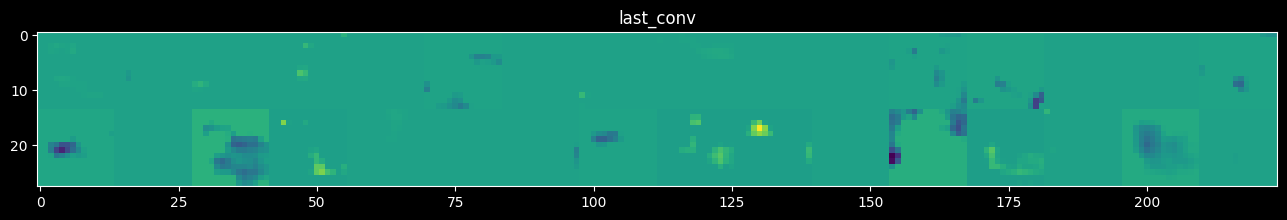

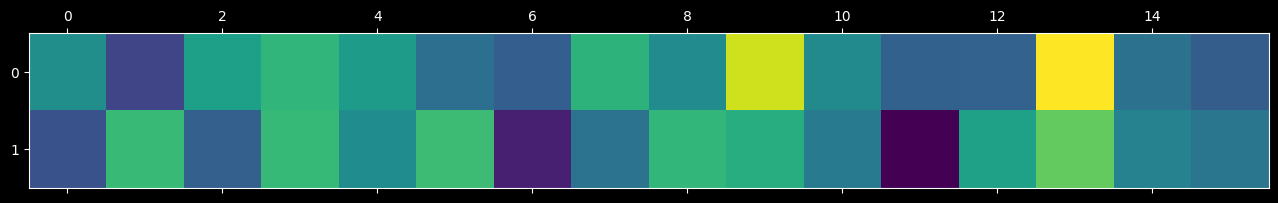

In [ ]:
# visualization
import cv2 # you need “conda install opencv”
img=cv2.imread(img_path)
heatmap=cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap=np.uint8(255*heatmap)
heatmap=cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img=heatmap*0.4+img
cv2.imwrite('1569_2.jpg', superimposed_img)

# visualization of conv_output and pooled_grads
draw_no=range(256,256+32,1)
conv_activation=np.expand_dims(conv_output[:,:,draw_no], axis=0)
draw_activation(conv_activation, 'last_conv') # in the chapter 5.4.1
plt.show()
plt.matshow(pooled_grads[draw_no].reshape(-1,16), cmap='viridis')

In [ ]:
layer_names=[layer.name for layer in model.layers[:8]] 

for figure_name, activation in zip(layer_names, activations):
    draw_activation(activation, figure_name)

NameError: name 'activations' is not defined